#**The scenario**

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.


##Load the houseprices data from Thinkful's database.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox, jarque_bera, normaltest
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import RidgeCV
from scipy.stats import norm
from sqlalchemy import create_engine
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings(action="ignore")

###**Functions**

**kfold function**

In [2]:
def model_train_test(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)

# We are making predictions here
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    print("R-squared of the model on the training set is: {}".format(model.score(X_train, y_train)))
    print("-----Test set statistics-----")
    print("R-squared of the model on the test set is: {}".format(model.score(X_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


    plt.scatter(y_test, y_preds_test)
    plt.plot(y_test, y_test, color = 'red')
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("Charges: true and predicted values")
    plt.show()

**model train test function**

In [3]:
# This version of the function returns a dict of stats we can use to compare various models' performance,
#  if five folds are defined.
def kfold(model,train_data,target_data,cv):
    print("Cross-validation using {} folds".format(cv))
    cross_val_array = cross_val_score(model, train_data, target_data, cv=cv)

    coss_val_dict = {'Model': str(model),
                    'Fold_1': cross_val_array[0],
                    'Fold_2': cross_val_array[1],
                    'Fold_3': cross_val_array[2],
                    'Fold_4': cross_val_array[3],
                    'Fold_5': cross_val_array[4],
                   }
    print("Fold_1:",cross_val_array[0])
    print("Fold_2:",cross_val_array[1])
    print("Fold_3:",cross_val_array[2])
    print("Fold_4:",cross_val_array[3])
    print("Fold_5:",cross_val_array[4])
    print("Accuracy:",cross_val_array.mean()*100)
    return(coss_val_dict)


###**Load the housing prices data from Thinkful's database.**

In [4]:

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


**Variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)**

In [5]:
house_df.shape

(1460, 81)

In [6]:
house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


##**Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.**

##Exploratory Data Analysis

In [7]:
#! pip install pandas-profiling
#! pip install pandas-profiling==2.*
#from pandas_profiling import ProfileReport

In [8]:
#ProfileReport(house_df)
#ProfileReport(house_df, minimal=True)

###Data Cleaning

**Missing Values & Data types**

Let's take a look at the missing data and data types:

In [9]:
#count missing values
missing_vals = (house_df.isnull().sum()*100/len(house_df)).sort_values(ascending=False)

#keep column names that do have them
missing_vals = missing_vals[missing_vals > 0]

# data types
missing_vals_datatype = house_df[missing_vals.index.to_list()].dtypes

print("**Missing value percentages:**")
print(missing_vals, '\n')
print("**Data types of missing values:**")
print(missing_vals_datatype, '\n')


**Missing value percentages:**
poolqc          99.520548
miscfeature     96.301370
alley           93.767123
fence           80.753425
fireplacequ     47.260274
lotfrontage     17.739726
garagecond       5.547945
garagetype       5.547945
garageyrblt      5.547945
garagefinish     5.547945
garagequal       5.547945
bsmtexposure     2.602740
bsmtfintype2     2.602740
bsmtfintype1     2.534247
bsmtcond         2.534247
bsmtqual         2.534247
masvnrarea       0.547945
masvnrtype       0.547945
electrical       0.068493
dtype: float64 

**Data types of missing values:**
poolqc           object
miscfeature      object
alley            object
fence            object
fireplacequ      object
lotfrontage     float64
garagecond       object
garagetype       object
garageyrblt     float64
garagefinish     object
garagequal       object
bsmtexposure     object
bsmtfintype2     object
bsmtfintype1     object
bsmtcond         object
bsmtqual         object
masvnrarea      float64
masvnrtype      

As you can see **poolqc** is missing 99.5%, **miscfeature** is missing 96.3% **alley** is missing 93.8% **fence** is missing 80.8% **fireplacequ** is missing 47.3% and  **lotfrontage** is missing 17.7% of data.

Dropping poolqc , miscfeature , alley , fence and  fireplacequ from our dataset 

In [10]:
#print(missing_vals[:5].index.to_list())
# drop 'poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ' and 'id' variables
drop_cols = missing_vals[:5].index.to_list()

drop_cols.extend(['id'])

house_df.drop(columns=drop_cols, inplace=True)

**Now fill variables with its own most frequent value**

In [11]:
house_df = house_df.apply(lambda x:x.fillna(x.value_counts().index[0]))

**Let's take a look at our target model's distribution:**

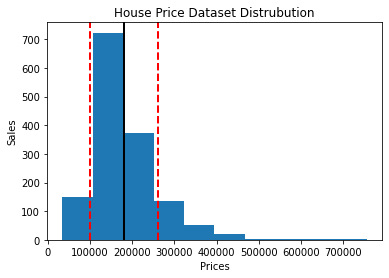

saleprice mean: $180921


In [12]:
salep = house_df.saleprice
plt.hist(salep)
plt.title('House Price Dataset Distrubution')
plt.xlabel('Prices')
plt.ylabel('Sales')
plt.axvline(salep.mean(), color='black', linestyle='solid', linewidth=2)
plt.axvline(salep.mean() + salep.std(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(salep.mean() - salep.std(), color='red', linestyle='dashed', linewidth=2) 
plt.show()
print('saleprice mean: ${}'.format(round(np.mean(salep))))


The target variable is right-skewed with a somewhat high peak in terms of kurtosis. The mean is 180,921 and prices reach a stretch above 600,000. Let's check how much of the data is captured:

**Let's draw distributions of features:**

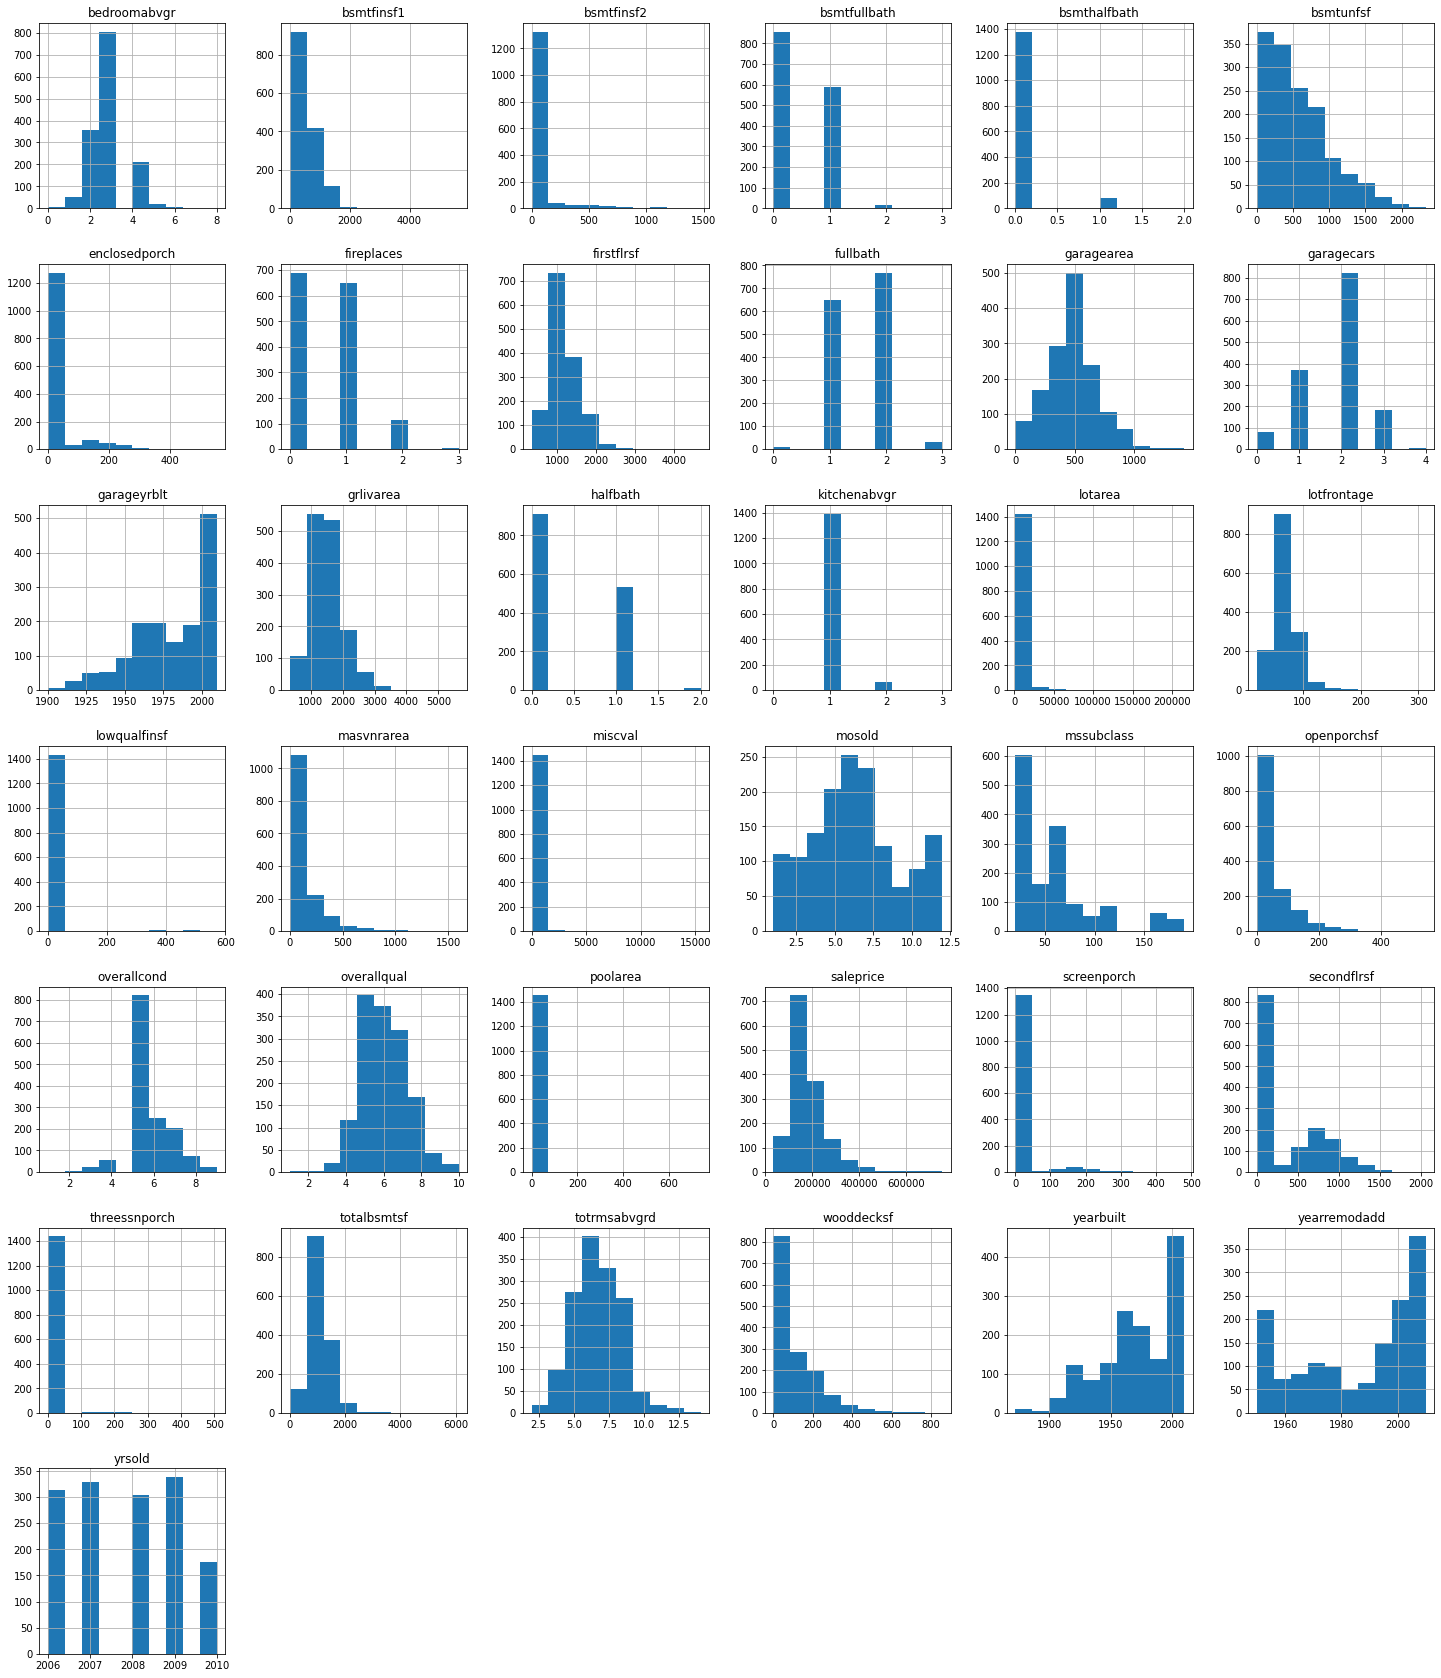

In [13]:
house_df.hist(figsize=(25,30))
plt.show()

**Dealing with outliers using winsorize function (they will not be deleted in order not to lose important information)**

In [14]:
winsor_house_df = house_df.copy()

In [15]:
# Pick numerical columns
#numeric_column = house_df.select_dtypes(include=[np.number]).columns.to_list()
#print(numeric_column)

columns = ['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 
           'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 
           'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 
           'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch',
           'screenporch', 'miscval', 'mosold', 'yrsold', 'saleprice']
for column in columns:
  winsor_house_df[column] = winsorize(winsor_house_df[column], (0.05,0.01))

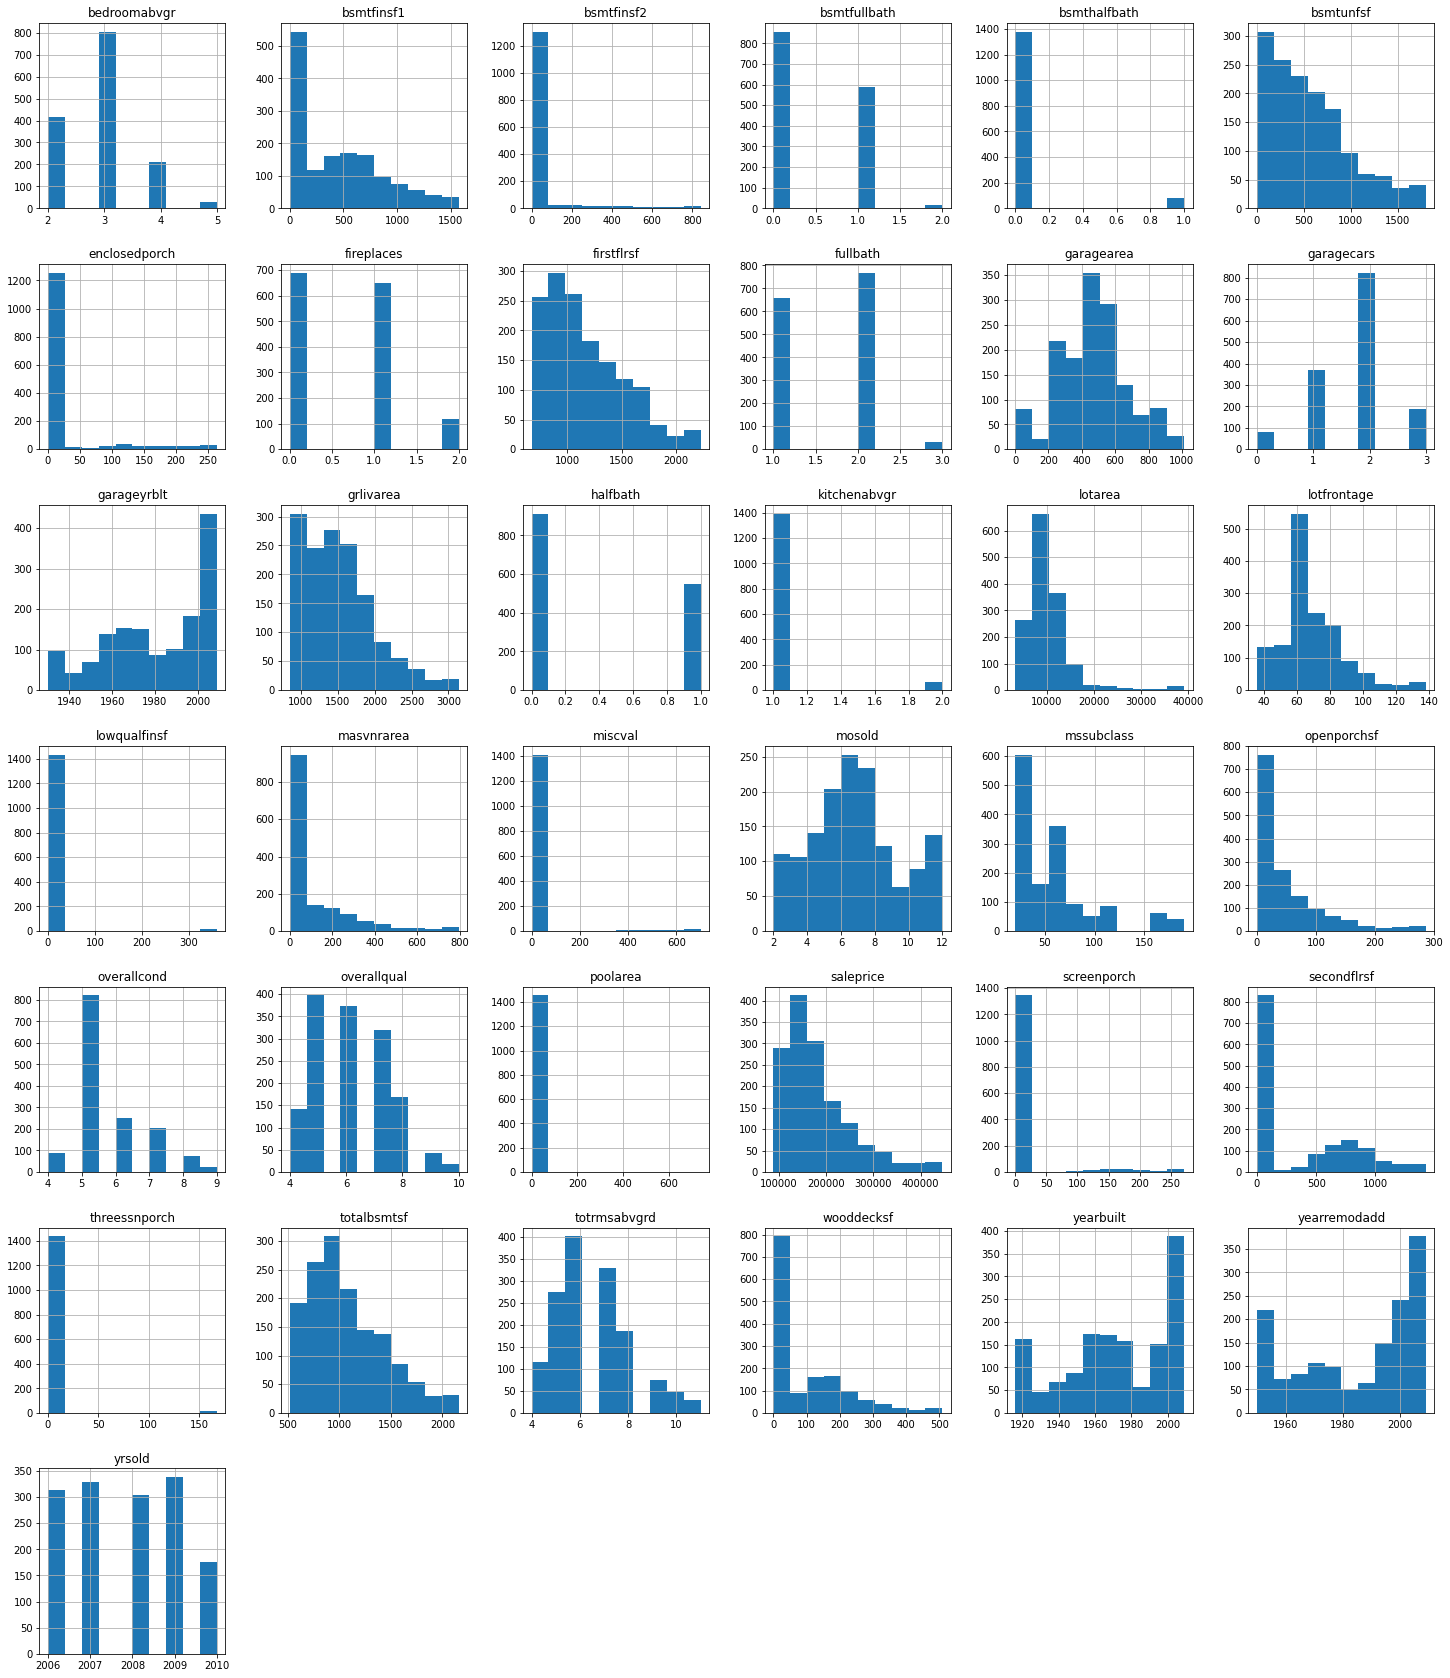

In [16]:
winsor_house_df.hist(figsize=(25,30))
plt.show()

**We see that after winsorizing the outliers of our dataset, some feature became more normal than before. This should contribute to enhancing our regression models.**

###Features's relation with the target variable

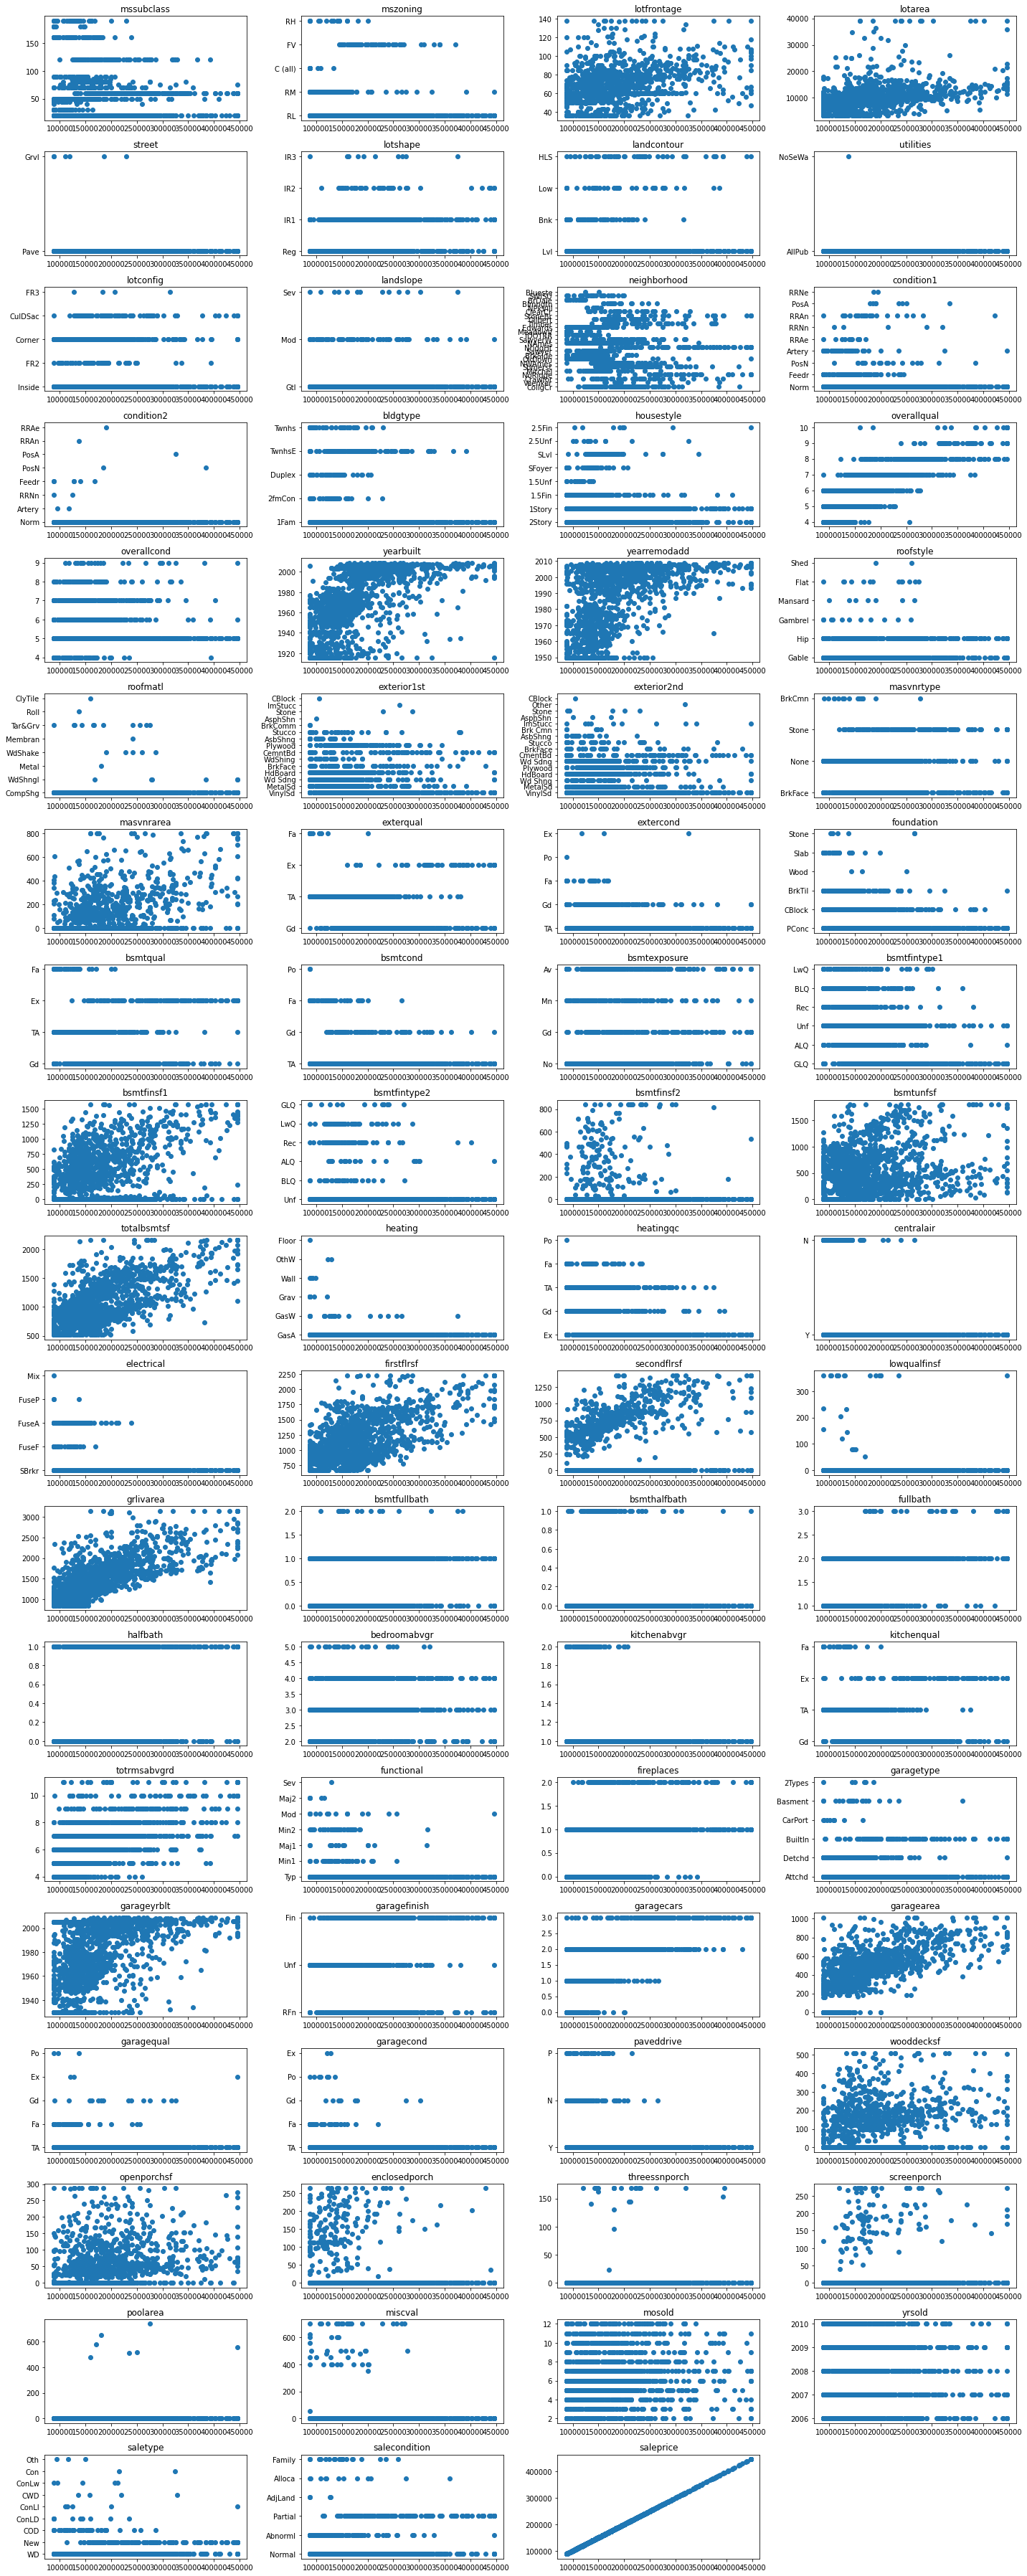

In [17]:
#Features's relation with the target variable
plt.figure(figsize = (20, 50))
i = 0
for column in winsor_house_df.columns:
  i +=1
  plt.tight_layout()
  plt.subplot(19, 4, i)
  plt.scatter(winsor_house_df['saleprice'], winsor_house_df[column])
  plt.title(column)

**Plot different bar plots for features against the target**

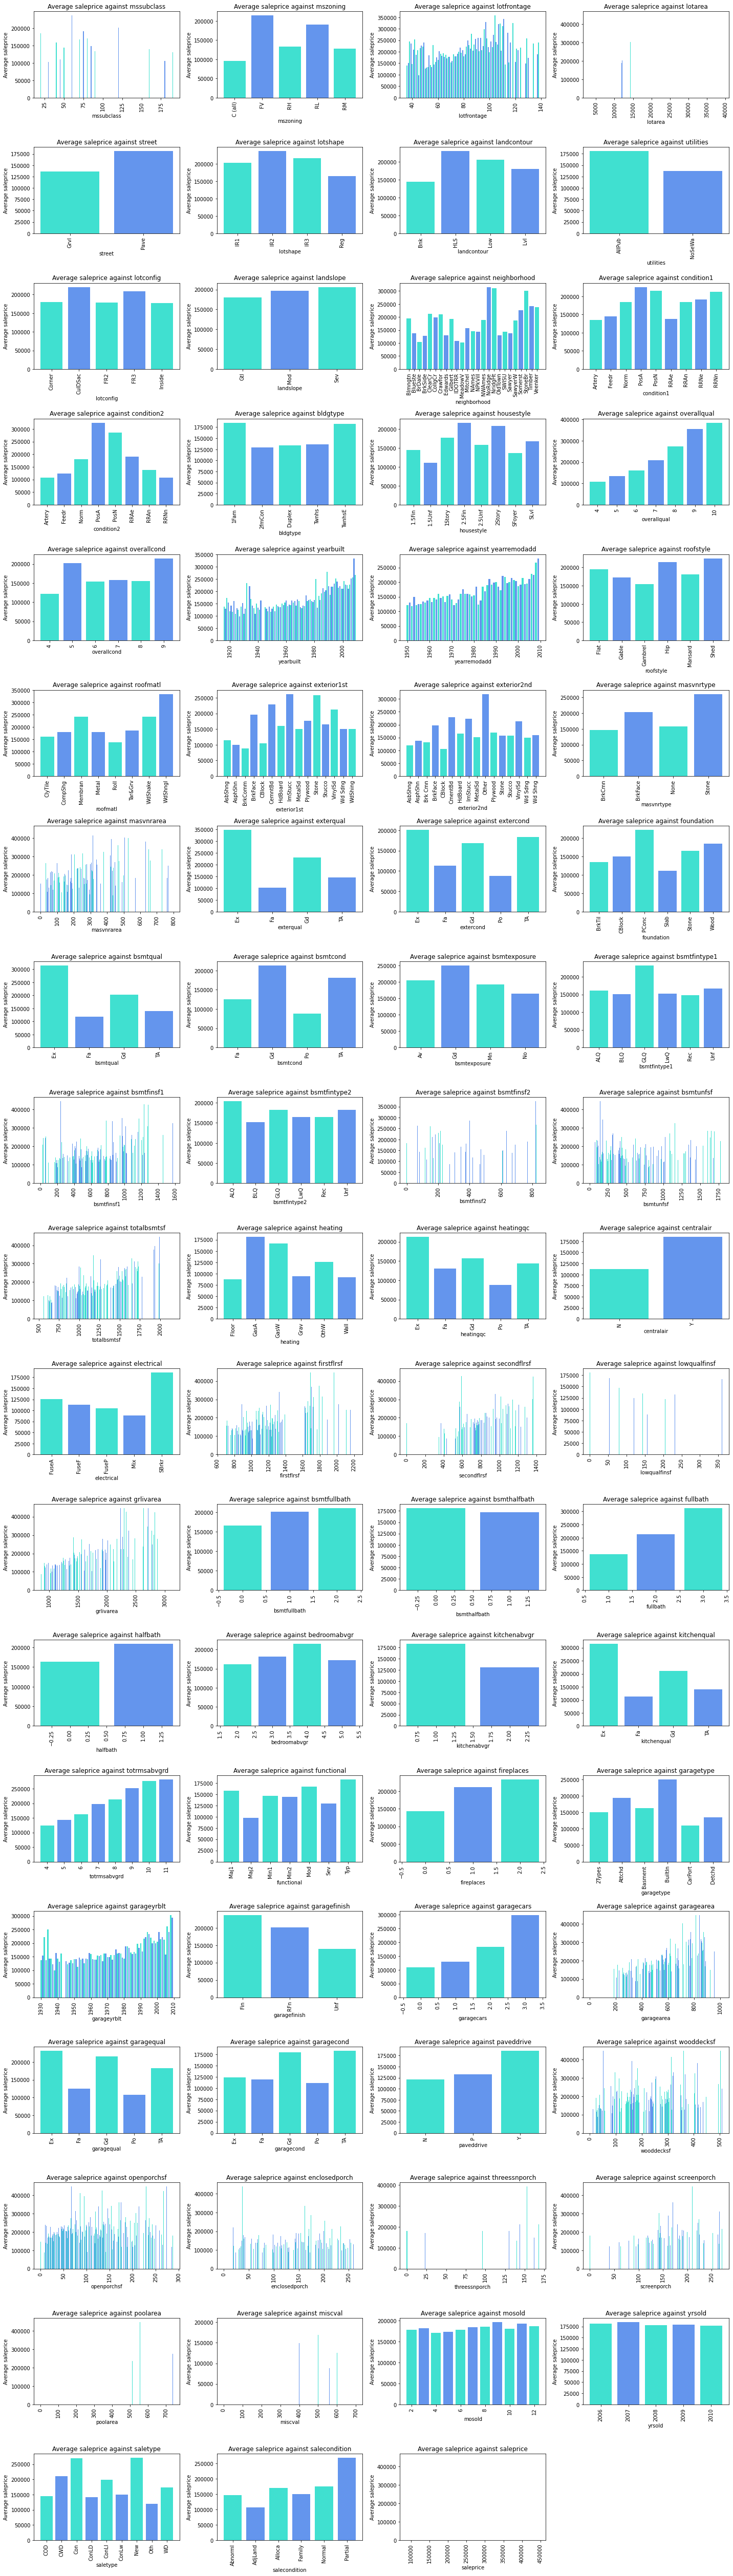

In [18]:
plt.figure(figsize = (20, 70))
i = 0
for column in winsor_house_df.columns:
  i +=1
  plt.subplot(19, 4, i)
  #plt.bar(winsor_house_df['saleprice'], winsor_house_df[column])
  plt.bar(winsor_house_df.groupby(column)["saleprice"].mean().index, winsor_house_df.groupby(column)["saleprice"].mean(),color=('turquoise','cornflowerblue'))
  plt.title("Average saleprice against {}".format(column))
  plt.ylabel("Average saleprice")
  plt.xlabel(column)
  plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

The multi-plot figure above makes it easy to see relationships of features with the target. Neighborhoods, street paving, heating and other variables. Since we are looking at a dataset of house sales, one good way to start is by looking at prices across neighborhoods. Houses of the same neighborhood are usually sold for a price within a fixed range for that neighborhood, that price usually encompasses several attributes like lot size, land class, year built and others, possibly making it a highly-correlated feature in our model



Let's check what is the mean price of a neighborhood 

In [19]:
winsor_house_df.groupby("neighborhood").mean().sort_values(by=['saleprice'],ascending=False)

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NoRidge,53.658537,84.243902,14036.341463,7.926829,5.219512,1995.439024,1996.658537,389.292683,814.000000,5.951220,653.926829,1443.975610,1480.341463,948.536585,0.000000,2431.170732,0.682927,0.024390,2.097561,0.902439,3.512195,1.000000,8.292683,1.097561,1995.487805,2.634146,704.585366,196.146341,75.121951,28.585366,0.000000,11.000000,13.536585,0.000000,6.292683,2007.829268,315625.658537
NridgHt,62.077922,81.701299,10924.103896,8.259740,5.000000,2005.675325,2006.129870,325.857143,684.506494,13.220779,869.688312,1571.792208,1573.415584,336.181818,0.000000,1915.948052,0.558442,0.000000,2.038961,0.415584,2.740260,1.000000,7.662338,1.012987,2005.792208,2.662338,737.623377,151.571429,75.532468,0.000000,2.181818,15.038961,0.000000,0.000000,6.896104,2007.818182,310115.116883
StoneBr,83.200000,62.160000,10095.920000,8.160000,5.080000,1998.440000,1998.800000,173.360000,809.680000,49.520000,629.560000,1520.680000,1547.880000,320.520000,0.000000,1873.520000,0.760000,0.000000,1.920000,0.400000,2.560000,1.000000,6.880000,0.840000,1998.520000,2.400000,625.440000,164.960000,51.080000,25.920000,6.720000,27.760000,0.000000,0.000000,7.640000,2007.920000,300193.600000
Timber,39.473684,75.578947,15248.631579,7.157895,5.131579,1992.842105,1993.315789,159.947368,708.500000,60.605263,580.105263,1358.105263,1445.921053,285.684211,0.000000,1749.368421,0.657895,0.052632,1.894737,0.368421,2.921053,1.000000,7.131579,1.026316,1993.447368,2.368421,621.605263,137.894737,50.789474,10.342105,0.000000,15.421053,0.000000,18.421053,5.973684,2007.815789,242247.447368
Veenker,61.818182,60.727273,14590.818182,6.727273,6.272727,1982.363636,1989.818182,32.727273,794.181818,188.454545,276.000000,1321.272727,1411.272727,128.363636,0.000000,1539.636364,0.909091,0.090909,1.454545,0.727273,2.545455,1.000000,6.000000,1.181818,1982.363636,2.090909,546.909091,158.909091,50.181818,0.000000,0.000000,56.363636,0.000000,0.000000,7.000000,2007.000000,238772.727273
Somerst,74.186047,65.465116,7959.546512,7.337209,5.034884,2004.988372,2005.302326,135.965116,325.476744,0.000000,804.627907,1133.046512,1144.767442,459.802326,2.790698,1596.651163,0.313953,0.000000,1.988372,0.581395,2.709302,1.000000,6.418605,0.465116,2005.058140,2.267442,628.313953,69.174419,100.279070,0.000000,0.000000,5.395349,0.000000,0.000000,6.279070,2007.744186,225379.837209
ClearCr,52.500000,70.892857,21526.071429,5.892857,5.678571,1966.857143,1983.750000,84.571429,620.892857,142.035714,446.964286,1244.928571,1309.321429,463.714286,12.857143,1788.107143,0.642857,0.178571,1.642857,0.321429,3.071429,1.000000,6.857143,1.142857,1970.607143,1.750000,468.428571,188.821429,64.821429,29.535714,4.642857,34.928571,0.000000,32.142857,6.785714,2007.785714,212565.428571
Crawfor,58.235294,69.490196,11809.686275,6.274510,6.607843,1941.803922,1979.196078,81.117647,466.803922,43.960784,521.588235,1034.470588,1258.529412,518.313725,7.058824,1788.705882,0.352941,0.098039,1.509804,0.411765,3.000000,1.058824,7.196078,1.235294,1953.313725,1.627451,410.078431,52.568627,27.000000,45.705882,9.588235,29.176471,0.000000,13.725490,6.882353,2007.490196,210624.725490
CollgCr,43.300000,69.813333,9619.146667,6.640000,5.240000,1997.886667,1999.140000,97.226667,456.586667,26.526667,673.360000,1157.586667,1164.626667,315.873333,0.000000,1482.020000,0.493333,0.020000,1.753333,0.386667,2.886667,1.000000,6.400000,0.393333,1998.773333,2.006667,552.326667,113.873333,51.720000,0.226667,2.080000,4.186667,0.000000,7.666667,6.200000,2007.806667,197965.773333


NoRidge, NridgHt and StoneBr are the most expensive neighborhoods in this dataset. Some of their features are significantly different than those of other neighborhoods

Categorizing the neighborhood into four category

* 1 = fair
* 2 = good
* 3 = very good
* 4 = luxurious


In [20]:
def classify_neighbor(saleprice):
    """ puts houses in preset neighborhood bins """
    
    neighborhood_class = {1:'saleprice < 120000',
                 2:'saleprice >= 120000 and saleprice < 200000',
                 3:'saleprice >= 200000 and saleprice < 300000',
                 4:'saleprice >= 300000'}
    for class_level in neighborhood_class.keys():
        if eval(neighborhood_class[class_level]):
            return class_level

winsor_house_df['neighborhood_class'] = winsor_house_df['saleprice'].apply(classify_neighbor)

###**Correlation**

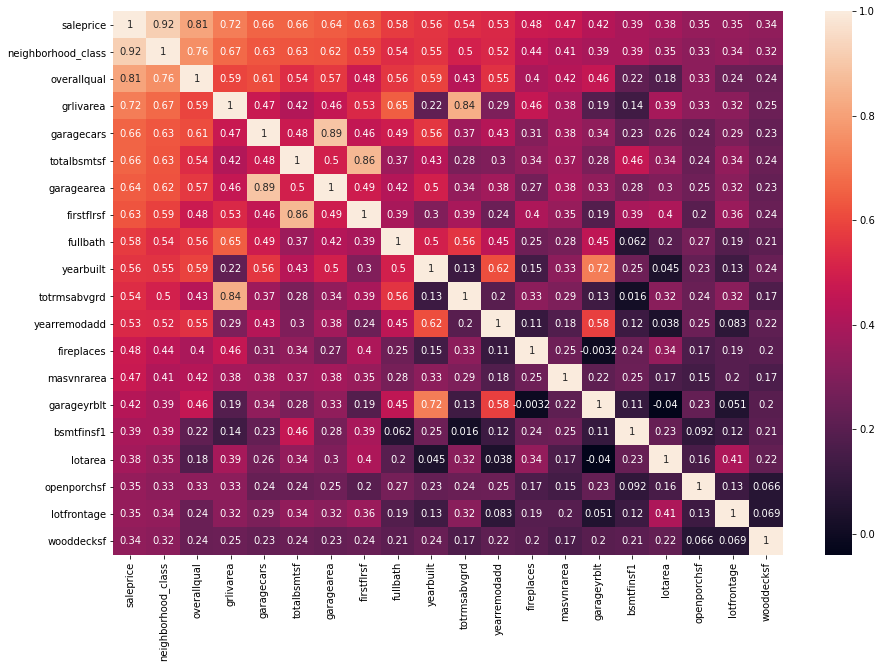

In [21]:
overall_correlation = winsor_house_df.corr()
correlated_columns = overall_correlation['saleprice'].sort_values(ascending=False).head(20).index
correlation = winsor_house_df[correlated_columns].corr()
fig=plt.figure(figsize=(15,10))
sns.heatmap(correlation,annot=True)



**Correlation matrix between the top 7 correlated features to the target variable**

In [22]:
corr = correlation['saleprice']
bestfeatures = (corr[corr>0.6])
bestfeatures = bestfeatures.drop('saleprice')
bestfeatures.sort_values(ascending=False).head(7)


neighborhood_class    0.920004
overallqual           0.811609
grlivarea             0.719602
garagecars            0.661222
totalbsmtsf           0.659396
garagearea            0.644595
firstflrsf            0.626405
Name: saleprice, dtype: float64

Feature selection will take place based on the correlation of every feature of the dataset with saleprice. Given this assumption the top 7 features of the above table will be selected.

In [23]:
vars_of_interest = ['saleprice', 'neighborhood_class', 'overallqual', 'grlivarea', 
                    'garagecars','totalbsmtsf', 'firstflrsf']

house_feature_df = winsor_house_df[vars_of_interest]

In [24]:
house_feature_df.head()

,saleprice,neighborhood_class,overallqual,grlivarea,garagecars,totalbsmtsf,firstflrsf
0,208500,3,7,1710,2,856,856
1,181500,2,6,1262,2,1262,1262
2,223500,3,7,1786,2,920,920
3,140000,2,7,1717,3,756,961
4,250000,3,8,2198,3,1145,1145


In [25]:
house_feature_df.describe()

,saleprice,neighborhood_class,overallqual,grlivarea,garagecars,totalbsmtsf,firstflrsf
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180539.969178,2.197260,6.121233,1514.301370,1.763699,1066.852055,1162.145890
std,73393.432890,0.821736,1.336354,490.065166,0.739318,372.372517,358.131473
min,88000.000000,1.000000,4.000000,848.000000,0.000000,520.000000,673.000000
25%,129975.000000,2.000000,5.000000,1129.500000,1.000000,795.750000,882.000000
50%,163000.000000,2.000000,6.000000,1464.000000,2.000000,991.500000,1087.000000
75%,214000.000000,3.000000,7.000000,1776.750000,2.000000,1298.250000,1391.250000
max,446261.000000,4.000000,10.000000,3140.000000,3.000000,2158.000000,2223.000000


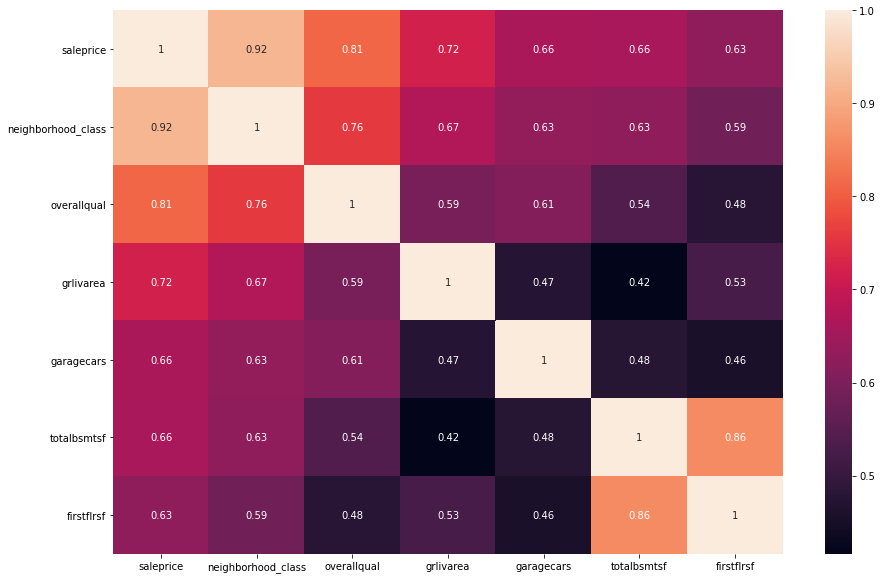

In [26]:
correlation = house_feature_df.corr()
fig=plt.figure(figsize=(15,10))
sns.heatmap(correlation,annot=True)

In [27]:
corr = correlation['saleprice']
bestfeatures = (corr[corr>0.66])
bestfeatures = bestfeatures.drop('saleprice')
bestfeatures.sort_values(ascending=False)


neighborhood_class    0.920004
overallqual           0.811609
grlivarea             0.719602
garagecars            0.661222
Name: saleprice, dtype: float64

It seems that PCA is not needed for this specific model as the features are few. Since we will be building several models,

##**Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!**

###**OLS**

**Performing a log transformation on the target variable (saleprice) made its distribution much more normal, and made the model fit better.**

In [28]:
# Y is the target variable
Y = np.log(house_feature_df['saleprice'])

####**OLS Model: 1**

neighborhood_class and overallqual highly correlated, so for that reason let's remove overallqual

features are: [ 'neighborhood_class', 'grlivarea', 'garagecars' ]

Our correlation threshold here is 0.66. This will be the initial basis on which we base our feature selection.

In [29]:
# X is the feature set.
#features1 = ['neighborhood_class', 'grlivarea', 'garagecars', 'firstflrsf', 'totalbsmtsf']
features1 = ['neighborhood_class', 'grlivarea', 'garagecars']
print("Features of this model: {}".format(features1))

X = winsor_house_df[features1]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['neighborhood_class', 'grlivarea', 'garagecars']
The number of observations in training set is 1168
The number of observations in test set is 292


In [30]:
# Capture k-fold output in a dataframe, so comparing performance will be easier
kfold_df = pd.DataFrame(columns=['Model','Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'])

In [31]:
linear = LinearRegression()
cv_results = kfold(linear,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.9105171126709902
Fold_2: 0.9159925648182221
Fold_3: 0.9090825414776266
Fold_4: 0.9070814806259642
Fold_5: 0.8998103389936659
Accuracy: 90.84968077172938
{'Model': 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)', 'Fold_1': 0.9105171126709902, 'Fold_2': 0.9159925648182221, 'Fold_3': 0.9090825414776266, 'Fold_4': 0.9070814806259642, 'Fold_5': 0.8998103389936659}


R-squared of the model on the training set is: 0.9099686606438375
-----Test set statistics-----
R-squared of the model on the test set is: 0.8948753828289391
Mean absolute error of the prediction is: 0.0978373116715343
Mean squared error of the prediction is: 0.014458206766636691
Root mean squared error of the prediction is: 0.12024228360538022
Mean absolute percentage error of the prediction is: 0.8123163426546596


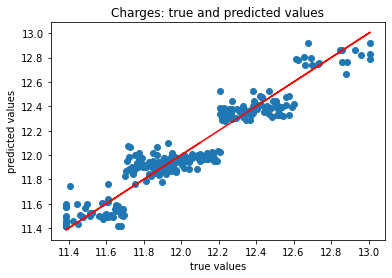

In [32]:
model_train_test(linear,X_train,y_train,X_test,y_test)

####**OLS Model: 2**


This is the most up-to-date model from previous lessons.

In [33]:
# X is the feature set.
features2 = ['overallqual', 'grlivarea', 'garagecars','firstflrsf','totalbsmtsf', 'yearremodadd', 'yearbuilt']
print("Features of this model: {}".format(features2))

X = winsor_house_df[features2]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['overallqual', 'grlivarea', 'garagecars', 'firstflrsf', 'totalbsmtsf', 'yearremodadd', 'yearbuilt']
The number of observations in training set is 1168
The number of observations in test set is 292


In [34]:
linear = LinearRegression()
cv_results = kfold(linear,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.8104060906662691
Fold_2: 0.8838049322316972
Fold_3: 0.8783607267811009
Fold_4: 0.8089562855304648
Fold_5: 0.8467113072216482
Accuracy: 84.56478684862361
{'Model': 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)', 'Fold_1': 0.8104060906662691, 'Fold_2': 0.8838049322316972, 'Fold_3': 0.8783607267811009, 'Fold_4': 0.8089562855304648, 'Fold_5': 0.8467113072216482}


R-squared of the model on the training set is: 0.8472274653920921
-----Test set statistics-----
R-squared of the model on the test set is: 0.8638310249863255
Mean absolute error of the prediction is: 0.10221296493299249
Mean squared error of the prediction is: 0.01872786078968626
Root mean squared error of the prediction is: 0.13684977453282945
Mean absolute percentage error of the prediction is: 0.8502174325911093


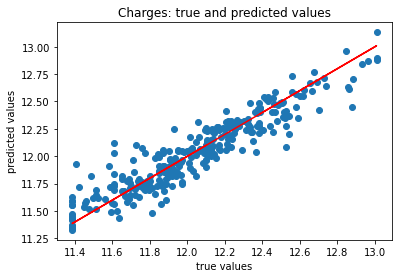

In [35]:
model_train_test(linear,X_train,y_train,X_test,y_test)

####**OLS Model: 3**

This model will take features from Model 1 and adds to it features from Model 2 that have low multicollinearity. This means we will be removing overallqual and grlivarea from Model 3:

In [36]:
# X is the feature set.
features3 = list(set(features1 + features2)-set(['overallqual','grlivarea']))
print("Features of this model: {}".format(features3))
X = winsor_house_df[features3]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['garagecars', 'totalbsmtsf', 'yearremodadd', 'yearbuilt', 'neighborhood_class', 'firstflrsf']
The number of observations in training set is 1168
The number of observations in test set is 292


In [37]:
linear = LinearRegression()
cv_results = kfold(linear,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.9161271147149326
Fold_2: 0.9158407425624399
Fold_3: 0.9047493930525983
Fold_4: 0.8952655550564962
Fold_5: 0.896012101612416
Accuracy: 90.55989813997766
{'Model': 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)', 'Fold_1': 0.9161271147149326, 'Fold_2': 0.9158407425624399, 'Fold_3': 0.9047493930525983, 'Fold_4': 0.8952655550564962, 'Fold_5': 0.896012101612416}


R-squared of the model on the training set is: 0.9076554910629425
-----Test set statistics-----
R-squared of the model on the test set is: 0.9097240246348077
Mean absolute error of the prediction is: 0.09379757167618948
Mean squared error of the prediction is: 0.012416013993809434
Root mean squared error of the prediction is: 0.1114271690110156
Mean absolute percentage error of the prediction is: 0.7786952212191598


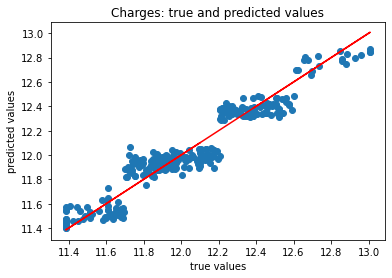

In [38]:
model_train_test(linear,X_train,y_train,X_test,y_test)

**This Model 3 is superior to both previous models and we can consider this model our best OLS model for now. Removing overallqual and grlivarea from Model II in order to replace them with neighborhood_class seems to have contributed a good bit to the model's .**

###**Ridge Regression**

####**Ridge Regression Model: 1**

In [39]:
# X is the feature set.
#features1 = ['neighborhood_class', 'grlivarea', 'garagecars', 'firstflrsf', 'totalbsmtsf']
features1 = ['neighborhood_class', 'grlivarea', 'garagecars']
print("Features of this model: {}".format(features1))

X = winsor_house_df[features1]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['neighborhood_class', 'grlivarea', 'garagecars']
The number of observations in training set is 1168
The number of observations in test set is 292


In [40]:
ridge = Ridge()
cv_results = kfold(ridge,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.9103888876352473
Fold_2: 0.9160104532792229
Fold_3: 0.9093254771119798
Fold_4: 0.9069995321099436
Fold_5: 0.8997657625813393
Accuracy: 90.84980225435466
{'Model': "Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n      normalize=False, random_state=None, solver='auto', tol=0.001)", 'Fold_1': 0.9103888876352473, 'Fold_2': 0.9160104532792229, 'Fold_3': 0.9093254771119798, 'Fold_4': 0.9069995321099436, 'Fold_5': 0.8997657625813393}


R-squared of the model on the training set is: 0.9099669919273526
-----Test set statistics-----
R-squared of the model on the test set is: 0.8948179613057425
Mean absolute error of the prediction is: 0.09782114914711616
Mean squared error of the prediction is: 0.014466104177134552
Root mean squared error of the prediction is: 0.12027511869515886
Mean absolute percentage error of the prediction is: 0.8121879832633097


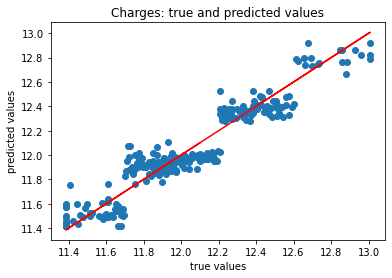

In [41]:
model_train_test(ridge,X_train,y_train,X_test,y_test)

####**Ridge Regression Model: 2**

In [42]:
# X is the feature set.
features2 = ['overallqual', 'grlivarea', 'garagecars','firstflrsf','totalbsmtsf', 'yearremodadd', 'yearbuilt']
print("Features of this model: {}".format(features2))

X = winsor_house_df[features2]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['overallqual', 'grlivarea', 'garagecars', 'firstflrsf', 'totalbsmtsf', 'yearremodadd', 'yearbuilt']
The number of observations in training set is 1168
The number of observations in test set is 292


In [43]:
ridge = Ridge()
cv_results = kfold(ridge,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.8103994341095386
Fold_2: 0.8838249370770787
Fold_3: 0.8783554626597989
Fold_4: 0.8089814508112134
Fold_5: 0.846677350236522
Accuracy: 84.56477269788303
{'Model': "Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n      normalize=False, random_state=None, solver='auto', tol=0.001)", 'Fold_1': 0.8103994341095386, 'Fold_2': 0.8838249370770787, 'Fold_3': 0.8783554626597989, 'Fold_4': 0.8089814508112134, 'Fold_5': 0.846677350236522}


R-squared of the model on the training set is: 0.8472273491847716
-----Test set statistics-----
R-squared of the model on the test set is: 0.8638546926707168
Mean absolute error of the prediction is: 0.10221007282996598
Mean squared error of the prediction is: 0.018724605678906044
Root mean squared error of the prediction is: 0.13683788100853522
Mean absolute percentage error of the prediction is: 0.8501902518671495


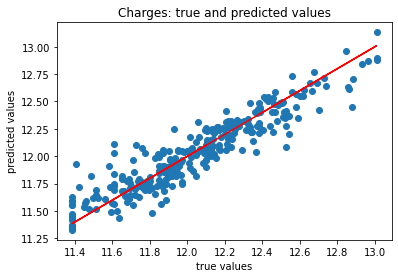

In [44]:
model_train_test(ridge,X_train,y_train,X_test,y_test)

####**Ridge Regression Model: 3**

So far OLD Model 3 predicting best results. Let's use the same features for Ridge Regression Model

In [45]:
# X is the feature set.
features3 = list(set(features1 + features2)-set(['overallqual','grlivarea']))
print("Features of this model: {}".format(features3))
X = winsor_house_df[features3]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['garagecars', 'totalbsmtsf', 'yearremodadd', 'yearbuilt', 'neighborhood_class', 'firstflrsf']
The number of observations in training set is 1168
The number of observations in test set is 292


In [46]:
ridge = Ridge()
cv_results = kfold(ridge,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.9160758956414665
Fold_2: 0.9158978390324819
Fold_3: 0.9049845302841896
Fold_4: 0.8951293835959525
Fold_5: 0.8959150263956611
Accuracy: 90.56005349899505
{'Model': "Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n      normalize=False, random_state=None, solver='auto', tol=0.001)", 'Fold_1': 0.9160758956414665, 'Fold_2': 0.9158978390324819, 'Fold_3': 0.9049845302841896, 'Fold_4': 0.8951293835959525, 'Fold_5': 0.8959150263956611}


R-squared of the model on the training set is: 0.9076535373514765
-----Test set statistics-----
R-squared of the model on the test set is: 0.9097830969446438
Mean absolute error of the prediction is: 0.09377644861357265
Mean squared error of the prediction is: 0.012407889544058479
Root mean squared error of the prediction is: 0.11139070672214302
Mean absolute percentage error of the prediction is: 0.7785109529499544


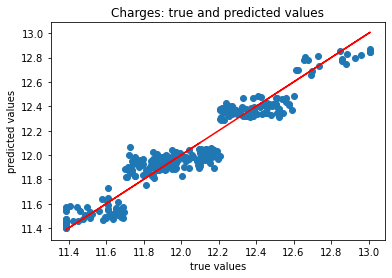

In [47]:
model_train_test(ridge,X_train,y_train,X_test,y_test)

###**Lasso**

####**Lasso Model: 1**

In [48]:
# X is the feature set.
#features1 = ['neighborhood_class', 'grlivarea', 'garagecars', 'firstflrsf', 'totalbsmtsf']
features1 = ['neighborhood_class', 'grlivarea', 'garagecars']
print("Features of this model: {}".format(features1))

X = winsor_house_df[features1]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['neighborhood_class', 'grlivarea', 'garagecars']
The number of observations in training set is 1168
The number of observations in test set is 292


In [49]:
lasso = Lasso()
cv_results = kfold(lasso,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.5073845320618859
Fold_2: 0.5440170782667153
Fold_3: 0.5820527209895239
Fold_4: 0.5058346030486435
Fold_5: 0.41926461665520454
Accuracy: 51.17107102043945
{'Model': "Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n      normalize=False, positive=False, precompute=False, random_state=None,\n      selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.5073845320618859, 'Fold_2': 0.5440170782667153, 'Fold_3': 0.5820527209895239, 'Fold_4': 0.5058346030486435, 'Fold_5': 0.41926461665520454}


R-squared of the model on the training set is: 0.5160158345625416
-----Test set statistics-----
R-squared of the model on the test set is: 0.5307642296242832
Mean absolute error of the prediction is: 0.1968600033588041
Mean squared error of the prediction is: 0.0645358620365257
Root mean squared error of the prediction is: 0.2540390954883238
Mean absolute percentage error of the prediction is: 1.631975280476081


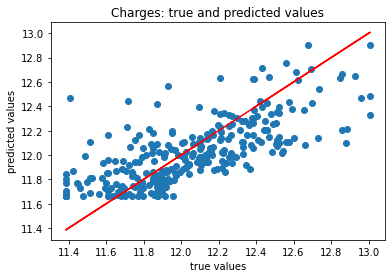

In [50]:
model_train_test(lasso,X_train,y_train,X_test,y_test)

####**Lasso Model: 2**

In [51]:
# X is the feature set.
features2 = ['overallqual', 'grlivarea', 'garagecars','firstflrsf','totalbsmtsf', 'yearremodadd', 'yearbuilt']
print("Features of this model: {}".format(features2))

X = winsor_house_df[features2]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['overallqual', 'grlivarea', 'garagecars', 'firstflrsf', 'totalbsmtsf', 'yearremodadd', 'yearbuilt']
The number of observations in training set is 1168
The number of observations in test set is 292


In [52]:
lasso = Lasso()
cv_results = kfold(lasso,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.7289133878111738
Fold_2: 0.8179038478998851
Fold_3: 0.8222179443381145
Fold_4: 0.7634092909711425
Fold_5: 0.7429278509049713
Accuracy: 77.50744643850574
{'Model': "Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n      normalize=False, positive=False, precompute=False, random_state=None,\n      selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.7289133878111738, 'Fold_2': 0.8179038478998851, 'Fold_3': 0.8222179443381145, 'Fold_4': 0.7634092909711425, 'Fold_5': 0.7429278509049713}


R-squared of the model on the training set is: 0.7774862046850859
-----Test set statistics-----
R-squared of the model on the test set is: 0.8085747293625222
Mean absolute error of the prediction is: 0.12153649974658674
Mean squared error of the prediction is: 0.026327478926581386
Root mean squared error of the prediction is: 0.16225744644416595
Mean absolute percentage error of the prediction is: 1.0068661834817547


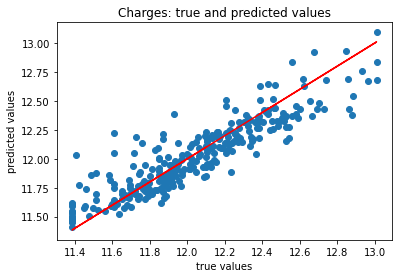

In [53]:
model_train_test(lasso,X_train,y_train,X_test,y_test)

####**Lasso Model: 3**

So far OLD Model 3 predicting best results. Let's use the same features for Ridge Regression Model

In [54]:
# X is the feature set.
features3 = list(set(features1 + features2)-set(['overallqual','grlivarea']))
print("Features of this model: {}".format(features3))
X = winsor_house_df[features3]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['garagecars', 'totalbsmtsf', 'yearremodadd', 'yearbuilt', 'neighborhood_class', 'firstflrsf']
The number of observations in training set is 1168
The number of observations in test set is 292


In [55]:
lasso = Lasso()
cv_results = kfold(lasso,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.5688989087439826
Fold_2: 0.622876570633963
Fold_3: 0.6163780401485588
Fold_4: 0.6153481887340253
Fold_5: 0.546652167636706
Accuracy: 59.403077517944716
{'Model': "Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n      normalize=False, positive=False, precompute=False, random_state=None,\n      selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.5688989087439826, 'Fold_2': 0.622876570633963, 'Fold_3': 0.6163780401485588, 'Fold_4': 0.6153481887340253, 'Fold_5': 0.546652167636706}


R-squared of the model on the training set is: 0.6014038563182714
-----Test set statistics-----
R-squared of the model on the test set is: 0.6560867038732285
Mean absolute error of the prediction is: 0.17459893024586903
Mean squared error of the prediction is: 0.04729976364247085
Root mean squared error of the prediction is: 0.21748508832209817
Mean absolute percentage error of the prediction is: 1.4453726520730292


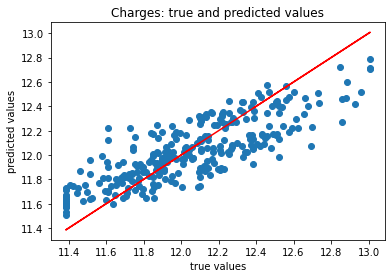

In [56]:
model_train_test(lasso,X_train,y_train,X_test,y_test)

###**ElasticNet regression**

Shifting the ratio to .01, favoring the Ridge penalty over the Lasso penalty, seems to yield good results.

####**ElasticNet regression Model: 1**

In [57]:
# X is the feature set.
#features1 = ['neighborhood_class', 'grlivarea', 'garagecars', 'firstflrsf', 'totalbsmtsf']
features1 = ['neighborhood_class', 'grlivarea', 'garagecars']
print("Features of this model: {}".format(features1))

X = winsor_house_df[features1]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['neighborhood_class', 'grlivarea', 'garagecars']
The number of observations in training set is 1168
The number of observations in test set is 292


In [58]:
elasticnet = ElasticNet(l1_ratio=.01)
cv_results = kfold(elasticnet,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.7117408237829622
Fold_2: 0.7419507932292981
Fold_3: 0.7754172834402637
Fold_4: 0.7121553861307469
Fold_5: 0.6722915687595166
Accuracy: 72.27111710685575
{'Model': "ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.01,\n           max_iter=1000, normalize=False, positive=False, precompute=False,\n           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.7117408237829622, 'Fold_2': 0.7419507932292981, 'Fold_3': 0.7754172834402637, 'Fold_4': 0.7121553861307469, 'Fold_5': 0.6722915687595166}


R-squared of the model on the training set is: 0.725243324926806
-----Test set statistics-----
R-squared of the model on the test set is: 0.7204493610865529
Mean absolute error of the prediction is: 0.15093644539651932
Mean squared error of the prediction is: 0.03844771137267601
Root mean squared error of the prediction is: 0.1960808796713132
Mean absolute percentage error of the prediction is: 1.2506243108972848


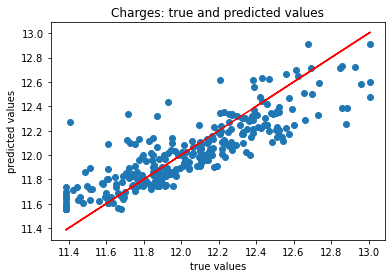

In [59]:
model_train_test(elasticnet,X_train,y_train,X_test,y_test)

####**ElasticNet regression Model: 2**


In [60]:
# X is the feature set.
features2 = ['overallqual', 'grlivarea', 'garagecars','firstflrsf','totalbsmtsf', 'yearremodadd', 'yearbuilt']
print("Features of this model: {}".format(features2))

X = winsor_house_df[features2]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['overallqual', 'grlivarea', 'garagecars', 'firstflrsf', 'totalbsmtsf', 'yearremodadd', 'yearbuilt']
The number of observations in training set is 1168
The number of observations in test set is 292


In [61]:
elasticnet = ElasticNet(l1_ratio=.01)
cv_results = kfold(elasticnet,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.787964798571196
Fold_2: 0.861609353431592
Fold_3: 0.8569938913780177
Fold_4: 0.794808865988045
Fold_5: 0.8037021934354334
Accuracy: 82.10158205608569
{'Model': "ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.01,\n           max_iter=1000, normalize=False, positive=False, precompute=False,\n           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.787964798571196, 'Fold_2': 0.861609353431592, 'Fold_3': 0.8569938913780177, 'Fold_4': 0.794808865988045, 'Fold_5': 0.8037021934354334}


R-squared of the model on the training set is: 0.8233301353946337
-----Test set statistics-----
R-squared of the model on the test set is: 0.8522982382565987
Mean absolute error of the prediction is: 0.10977457114143027
Mean squared error of the prediction is: 0.020314010824007776
Root mean squared error of the prediction is: 0.14252722836008486
Mean absolute percentage error of the prediction is: 0.9109639990993958


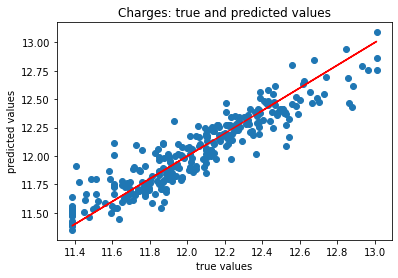

In [62]:
model_train_test(elasticnet,X_train,y_train,X_test,y_test)

####**ElasticNet regression Model: 3**


In [63]:
# X is the feature set.
features3 = list(set(features1 + features2)-set(['overallqual','grlivarea']))
print("Features of this model: {}".format(features3))
X = winsor_house_df[features3]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['garagecars', 'totalbsmtsf', 'yearremodadd', 'yearbuilt', 'neighborhood_class', 'firstflrsf']
The number of observations in training set is 1168
The number of observations in test set is 292


In [64]:
elasticnet = ElasticNet(l1_ratio=.01)
cv_results = kfold(elasticnet,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.7402983421512508
Fold_2: 0.7546455608748296
Fold_3: 0.7672251597763439
Fold_4: 0.7260605405607
Fold_5: 0.6969840928632415
Accuracy: 73.70427392452731
{'Model': "ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.01,\n           max_iter=1000, normalize=False, positive=False, precompute=False,\n           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.7402983421512508, 'Fold_2': 0.7546455608748296, 'Fold_3': 0.7672251597763439, 'Fold_4': 0.7260605405607, 'Fold_5': 0.6969840928632415}


R-squared of the model on the training set is: 0.7423371257107192
-----Test set statistics-----
R-squared of the model on the test set is: 0.7837474912614166
Mean absolute error of the prediction is: 0.13971991922468707
Mean squared error of the prediction is: 0.029742067740980586
Root mean squared error of the prediction is: 0.1724588871035082
Mean absolute percentage error of the prediction is: 1.1565986653433105


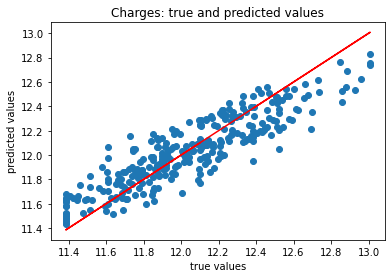

In [65]:
model_train_test(elasticnet,X_train,y_train,X_test,y_test)

###**Comparing scores from cross-validation**

In [66]:
kfold_df['avg_score'] = kfold_df.mean(axis=1)
kfold_df.sort_values(['avg_score'],ascending=False)


,Model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg_score
3,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.910389,0.916010,0.909325,0.907000,0.899766,0.908498
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.910517,0.915993,0.909083,0.907081,0.899810,0.908497
5,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.916076,0.915898,0.904985,0.895129,0.895915,0.905601
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.916127,0.915841,0.904749,0.895266,0.896012,0.905599
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.810406,0.883805,0.878361,0.808956,0.846711,0.845648
4,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.810399,0.883825,0.878355,0.808981,0.846677,0.845648
10,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",0.787965,0.861609,0.856994,0.794809,0.803702,0.821016
7,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.728913,0.817904,0.822218,0.763409,0.742928,0.775074
11,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",0.740298,0.754646,0.767225,0.726061,0.696984,0.737043
9,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",0.711741,0.741951,0.775417,0.712155,0.672292,0.722711


###**Comparing training vs. test output**


**The same OLS and Ridge model performed the best against the test dataset, with an $R^2$ value of 90.9%.**

**OLS Model: 3**
```
R-squared of the model on the training set is: 0.9076554910629425
-----Test set statistics-----
R-squared of the model on the test set is: 0.9097240246348077
Mean absolute error of the prediction is: 0.0937975716761897
Mean squared error of the prediction is: 0.012416013993809427
Root mean squared error of the prediction is: 0.11142716901101557
Mean absolute percentage error of the prediction is: 0.7786952212191615
```

**Ridge Model: 3**

```
R-squared of the model on the training set is: 0.9076535373514765
-----Test set statistics-----
R-squared of the model on the test set is: 0.9097830969446435
Mean absolute error of the prediction is: 0.09377644861357272
Mean squared error of the prediction is: 0.01240788954405849
Root mean squared error of the prediction is: 0.11139070672214307
Mean absolute percentage error of the prediction is: 0.7785109529499552
```





##So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

These variables can be obtained using the dates of house sales. Getting a range of years will enable us to obtain GDP (Gross Domestic Product), GNP (Gross National Product), and interest rate for the year of sale:

In [67]:
'This dataset contains house sales made between {} and {}.'.format(min(winsor_house_df['yrsold']),max(winsor_house_df['yrsold']))

'This dataset contains house sales made between 2006 and 2010.'

In [68]:
# These values were obtained from Google (source: World Bank)
gdp = [13.86,14.48,14.72,14.42,14.96]
int_rate = [5.87, 5.4, 2, 0.5, 0.75]
yrs = [i for i in range(2006,2011)]
gdp = {i:n for i in yrs for n in gdp}
int_rate = {i:n for i in yrs for n in int_rate}

# add the 2 columns
winsor_house_df['gdp'] = [gdp[i] for i in winsor_house_df['yrsold']]
winsor_house_df['int_rate'] = [int_rate[i] for i in winsor_house_df['yrsold']]

###**New Model: with gdp and interest rate feature**

In [69]:
# X is the feature set.
features4 = features3
features4.extend(['gdp','int_rate'])
print("Features of this model: {}".format(features4))
X = winsor_house_df[features3]

# add a constant to the model
X = sm.add_constant(X)

#split our data into train and test sets where 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

Features of this model: ['garagecars', 'totalbsmtsf', 'yearremodadd', 'yearbuilt', 'neighborhood_class', 'firstflrsf', 'gdp', 'int_rate']
The number of observations in training set is 1168
The number of observations in test set is 292


In [70]:
linear = LinearRegression()
cv_results = kfold(linear,X_train,y_train,cv=5)
print(cv_results)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
Fold_1: 0.9161271147149329
Fold_2: 0.9158407425624401
Fold_3: 0.9047493930525983
Fold_4: 0.8952655550564952
Fold_5: 0.8960121016124155
Accuracy: 90.55989813997763
{'Model': 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)', 'Fold_1': 0.9161271147149329, 'Fold_2': 0.9158407425624401, 'Fold_3': 0.9047493930525983, 'Fold_4': 0.8952655550564952, 'Fold_5': 0.8960121016124155}


R-squared of the model on the training set is: 0.9076554910629425
-----Test set statistics-----
R-squared of the model on the test set is: 0.9097240246348077
Mean absolute error of the prediction is: 0.0937975716761896
Mean squared error of the prediction is: 0.012416013993809408
Root mean squared error of the prediction is: 0.11142716901101547
Mean absolute percentage error of the prediction is: 0.7786952212191613


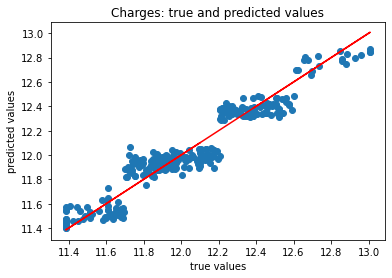

In [71]:
model_train_test(linear,X_train,y_train,X_test,y_test)

**New Model prediction was not better than OLS and Ridge Model:3 .This may be due to gdp and interest rates being very general metrics that need additional processing to be specific to this housing market.**